In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import itertools

plt.style.use('default')


In [2]:
knn_results_hepatitis = pd.read_csv("../data/per_fold_results/knn_hepatitis.csv")
# knn_results_mushroom = pd.read_csv("../data/per_fold_results/knn_mushroom.csv")
knn_reduction_results_hepatitis = pd.read_csv("../data/per_fold_results/knn_reduction_hepatitis.csv")
# knn_reduction_results_mushroom = pd.read_csv("../data/per_fold_results/knn_reduction_mushroom.csv")
svm_results_hepatitis = pd.read_csv("../data/per_fold_results/svm_hepatitis.csv")
# svm_results_mushroom = pd.read_csv("../data/per_fold_results/svm_mushroom.csv")

In [3]:
fold_cols = [f'fold{i}' for i in range(1, 11)]

for df in [knn_results_hepatitis, knn_reduction_results_hepatitis, svm_results_hepatitis]:
    df['mean_f1_score'] = df.loc[:, fold_cols].mean(axis=1)


In [4]:
def friedman_test(df_with_f1_per_fold):
    results = {
        i: df_with_f1_per_fold.loc[i, fold_cols] for i in df_with_f1_per_fold.index
    }
    f1_df = pd.DataFrame(results)
    statistic, p_value = stats.friedmanchisquare(*[f1_df[k] for k in f1_df])
    return statistic, p_value

def linear_sample(df_with_f1_per_fold, num_samples=8):
    num_samples = min(num_samples, len(df_with_f1_per_fold))
    samples_indices = np.linspace(0, len(df_with_f1_per_fold)-1, num_samples, dtype=int)
    return df_with_f1_per_fold.loc[samples_indices, :]

def top_samples(df_with_f1_per_fold, num_samples=8):
    num_samples = min(num_samples, len(df_with_f1_per_fold))
    return df_with_f1_per_fold.sort_values(by='mean_f1_score', ascending=False).head(num_samples)

friedman_test(linear_sample(svm_results_hepatitis))

(np.float64(32.687407407407385), np.float64(3.0272403715178655e-05))

In [5]:
num_sample_options = [4, 8, 16]
sample_types = ['linear', 'top']
models = ['KNN', 'SVM', 'KNN-Reduction']
dataframes = [knn_results_hepatitis, svm_results_hepatitis, knn_reduction_results_hepatitis]
data = []

for sample_type, num_samples, (model, df) in itertools.product(sample_types, num_sample_options, zip(models, dataframes)):
    sample_func = linear_sample if sample_type == 'linear' else top_samples
    
    p_value = friedman_test(sample_func(df, num_samples))[1]
    data.append({
        'model': model,
        'num_samples': num_samples,
        'sample_type': sample_type,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

p_values_df = pd.DataFrame(data)

p_values_df

,model,num_samples,sample_type,p_value,significant
0,KNN,4,linear,1.009070e-01,False
1,SVM,4,linear,1.439571e-03,True
2,KNN-Reduction,4,linear,6.715252e-02,False
3,KNN,8,linear,5.837940e-06,True
4,SVM,8,linear,3.027240e-05,True
5,KNN-Reduction,8,linear,6.715252e-02,False
6,KNN,16,linear,8.320052e-11,True
7,SVM,16,linear,6.589008e-09,True
8,KNN-Reduction,16,linear,6.715252e-02,False
9,KNN,4,top,8.012520e-01,False


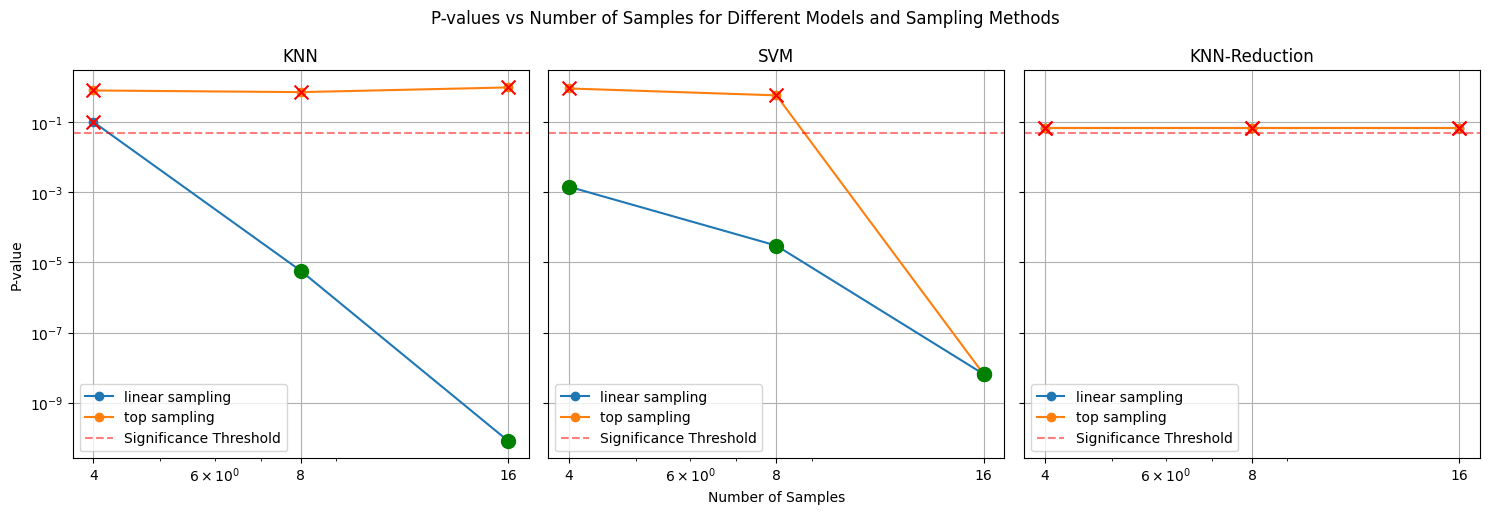

In [6]:
# TODO: only plot one point for KNN-Reduction

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle('P-values vs Number of Samples for Different Models and Sampling Methods')

for idx, model in enumerate(models):
    model_data = p_values_df[p_values_df['model'] == model]
    
    for sample_type in sample_types:
        data = model_data[model_data['sample_type'] == sample_type]
        
        # Plot the line
        axes[idx].plot(data['num_samples'], data['p_value'], marker='o', label=f"{sample_type} sampling")
        
        # Scatter significant points (green circle)
        significant = data[data['significant']]
        axes[idx].scatter(significant['num_samples'], significant['p_value'], 
                          color='green', marker='o', s=100, zorder=3)
        
        # Scatter non-significant points (red x)
        non_significant = data[~data['significant']]
        axes[idx].scatter(non_significant['num_samples'], non_significant['p_value'], 
                          color='red', marker='x', s=100, zorder=3)
    
    axes[idx].set_title(f'{model}')
    if idx == 0:  # Only show y-label for first subplot
        axes[idx].set_ylabel('P-value')
    axes[idx].set_yscale('log')  # Log scale for y-axis
    axes[idx].set_xscale('log')  # Log scale for x-axis
    axes[idx].set_xticks(num_sample_options)
    axes[idx].set_xticklabels(num_sample_options)
    axes[idx].axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='Significance Threshold')  # Add significance threshold line
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
axes[len(axes)//2].set_xlabel('Number of Samples')
fig.savefig('../reports/figures/p_values_vs_num_samples.png', dpi=300)
plt.show()
